CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - SVM Notebook

### *Dominic Murphy and David Modjeska*

#### (Using different hyperparameter set per currency, tuned for single-predictor FX rate models)

------

# Introduction

In [1]:
import math
import numpy as np
import pandas as pd
import re
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

%matplotlib inline
from IPython.display import Image, display, HTML

In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

In [3]:
default_c = 0.5
default_gamma = 0.01

# Modeling

*Note: some code has been adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

#### Helper function to convert a dataframe for supervised learning

In [4]:
def series_to_supervised(data, n_in = 1, n_out = 1, drop_nan = True):
    columns = data.columns.values
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(columns[j] + '(t)' % ()) for j in range(n_vars)]
        else:
            names += [(columns[j] + '(t+%d)' % (i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace = True)
    
    return agg

#### Load data

In [5]:
data = pd.read_csv('source_data.csv', parse_dates = ['date_key'])
print(data.shape)

(6554, 151)


#### Display first few rows of data

In [6]:
data.head()

,date_dayofyear,date_key,date_month,date_qtr,AU_IS_WORK_DAY,US_IS_WORK_DAY,CA_IS_WORK_DAY,UK_IS_WORK_DAY,IS_EURO,AU_FX,...,UK_FX_MA_090,UK_FX_MA_180,UK_FX_MA_365,temperature,AU_BMP_Ratio,CA_BMP_Ratio,UK_BMP_Ratio,CH_BMP_Ratio,JP_BMP_Ratio,time_index
0,3,2000-01-03,1,1,0,1,1,0,1,0.6591,...,1.628023,1.617005,1.617082,-0.943863,0.680107,0.784969,1.231594,3.715825,1.151735,0
1,4,2000-01-04,1,1,1,1,1,0,1,0.6562,...,1.627812,1.617446,1.617025,-0.940453,0.677115,0.782104,1.239163,3.658705,1.136206,1
2,5,2000-01-05,1,1,1,1,1,1,1,0.6550,...,1.627695,1.617946,1.616983,-0.940453,0.675876,0.782104,1.242570,3.649538,1.128760,2
3,6,2000-01-06,1,1,1,1,1,1,1,0.6540,...,1.627645,1.618471,1.616963,-0.936941,0.674845,0.779259,1.247112,3.652829,1.113523,3
4,7,2000-01-07,1,1,1,1,1,1,1,0.6548,...,1.627491,1.618938,1.616933,-0.936941,0.675670,0.782805,1.240223,3.672339,1.113735,4


#### Extract feature columns

In [7]:
feature_data = data.drop(['date_key', 'time_index'], axis = 1)
feature_cols = feature_data.columns
n_feature_cols = feature_data.shape[1]

## Helper functions

#### Calculate the latest start date among a set of features

In [8]:
euro_start_date = '2000-01-03'

def get_start_row_index(data, col_names):
    return(max([data[col].isnull().idxmin() for col in col_names]))

#### Reduce dimensionality of X by PCA

In [9]:
def pca_X(currency_name, X):
    
    # fit a PCA for exploration only
    n_pcs_total = int(100)
    pca = PCA(n_components = n_pcs_total, svd_solver = 'full', random_state = 0)
    pca.fit(X)
    ratios = np.cumsum(pca.explained_variance_ratio_)
    
    # scree plot of variances explained
    plt.plot(1.0 - ratios)
    plt.title(currency_name + " - PCA cumulative variance explained")
    plt.xlabel("Number of components")
    plt.ylabel("% of variance not explained")
    plt.show()
    
    # computer number of components to use
    n_pcs_to_use = 40
    print('Cumulative variance explained by the first ' + str(n_pcs_to_use) + ' components: ' + 
          str(np.round(ratios[n_pcs_to_use], 4)))
    
    # fit a PCA and transform the data
    pca = PCA(n_components = n_pcs_to_use, svd_solver = 'arpack', random_state = 0)
    pca.fit(X)    
    X_pca = pd.DataFrame(pca.transform(X))
    
    return(X_pca, pca)

#### Helper function to manage data reduction by PCA

In [10]:
def do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed):
    if do_pca and (n_past_lags > 1):
        X = this_data_reframed.iloc[:, :-1]        
        X_pca, pca = pca_X(currency_name, X)
        this_data_pca = X_pca        
        this_data_pca['y'] = this_data_reframed.iloc[:, -1].values 

        my_display("<h4>Shape of train and test data after PCA</h4>")
        print('Reduced data shape: ' + str(this_data_pca.shape))
    else:
        this_data_pca = this_data_reframed
        pca = None
        
    return(this_data_pca, pca)

#### Helper function to reframe data for supervised training

In [11]:
def reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols):
    this_data_reframed = series_to_supervised(this_data_scaled, n_past_lags, n_future_lags) # X, y, and extra
    this_data_reframed_past = this_data_reframed.iloc[:, :(n_past_lags*n_these_cols)] # X = past = predictor
    this_data_reframed_future = this_data_reframed.iloc[:, -n_these_cols] # y = future = response
    this_data_reframed = pd.concat([this_data_reframed_past, this_data_reframed_future], axis = 1) # X and y
    
    print('Reframed data shape: ' + str(this_data_reframed.shape))
    return(this_data_reframed)

#### Prepare data for one model

In [12]:
n_past_lags = 180
n_future_lags = 180

def prep_model_data(currency_name, col_names, do_pca = False, verbose = 2):
    my_display("<h3>Prepare model data</h3>")
    
    # extract untransformed data
    n_these_cols = len(col_names)
    start_row_index = get_start_row_index(data, col_names)
    this_data = data[col_names].iloc[start_row_index:, :]
    n_these_rows = this_data.shape[0]
    
    # print data's time period
    print("Time period: " + str(data.date_key.dt.date[0]) + ' - ' + 
          str(data.date_key.dt.date[n_these_rows - 1]))
    
    # list untransformed model features
    if not do_pca:
        my_display("<h4>Features in Model</h4>")
        print(*col_names, sep = ', ')
        print()
    
    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    this_data_scaled = pd.DataFrame(scaler.fit_transform(this_data))
    this_data_scaled.columns = col_names
    print('Scaled data shape: ' + str(this_data_scaled.shape))
    
    # reframe data for supervised training
    this_data_reframed = reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols)
    
    # convert reframed data for classification
    last_col_name = this_data_reframed.columns[-1]
    this_data_reframed['Is_Up'] = \
        np.where(this_data_reframed.iloc[:, -1] - this_data_reframed.iloc[:, 0] > 0, 1, 0)
    this_data_reframed = this_data_reframed.drop(last_col_name, axis = 1)

    # PCA X (if needed)
    this_data_pca, pca = do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed)
    
    # display first few rows of supervised data
    if (verbose == 2 and not do_pca):
        my_display("<h4>First few rows of supervised data</h4>")
        my_linespace()
        my_display_df(this_data_pca.head())
        my_linespace()

    # predict y naively as a coin flip
    yhat_naive = pd.DataFrame(np.ones(this_data_pca.shape[0]) * 0.5)
        
    # split into train and test sets
    train, test, yhat_naive_train, yhat_naive_test = \
        train_test_split(this_data_pca, yhat_naive, test_size = 0.33, shuffle = False, random_state = 0)
    
    # split into input and outputs
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    
    if verbose == 2:
        my_display("<h4>Shape of train and test data</h4>")
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return(train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_these_cols)

#### Helper function to optimize the hyperparameters using grid search

In [13]:
# helper function to do cross-validated grid search, to identify optimal parameter values
def grid_search_model(model, train_X, test_X, train_y, test_y, 
                      parm_1_name, parm_1_values, parm_2_name = None, parm_2_values = None): 
    
    # combine grid data
    grid_X = pd.concat([train_X, test_X], axis = 0)
    grid_y = pd.concat([train_y, test_y], axis = 0)
    
    # set 'fold' flags for predefined train/test split (-1 = train, 0 = test)
    fold_flags = np.concatenate([np.repeat(-1, train_X.shape[0]), np.repeat(0, test_X.shape[0])], axis = 0)
    
    # assemble parameters dictionary
    parameters = {parm_1_name : parm_1_values}
    if parm_2_name is not None:
        parameters[parm_2_name] = parm_2_values 
      
    # perform grid search
    ps = PredefinedSplit(fold_flags)
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = ps, n_jobs = 4, scoring = 'roc_auc')  
    _ = grid.fit(X = grid_X, y = grid_y)    
    best_parm_1_value = grid.best_params_[parm_1_name]
    best_parm_2_value = grid.best_params_[parm_2_name] if parm_2_name is not None else None

    # display best score and parameters
    my_linespace()
    my_display('Best AUC: ' +  str(round(grid.best_score_, 4)))
    my_display('Best ' + parm_1_name + ' = ' + str(grid.best_params_[parm_1_name]))
    if parm_2_name is not None:
        my_display('Best ' + parm_2_name + ' = ' + str(grid.best_params_[parm_2_name]))
        
    return_values = (best_parm_1_value, best_parm_2_value)
    return(return_values)

#### Helper function to perform feature selection

In [14]:
def select_best_features(currency_name, currency_prefix, fx_auc, 
                         C = default_c, gamma = default_gamma):
    fx_col_name = currency_prefix + '_FX'   
    best_features = [fx_col_name]
    best_score = fx_auc
    do_continue = True

    # collect candidate features
    feature_cols = data.columns.values
    pattern = currency_prefix + '_' + \
        '|US_|Aluminium|Beef|Copper|GAS_SPOT|GOLD|GOLD_FUT|GAS_FUT_1M|Tia_Rice|Wheat|gas_delta|gold_delta|wood'      
    candidate_col_names_0 = [feature_cols[i] for i in range(len(feature_cols)) 
                       if re.search(pattern, feature_cols[i])]
        
    while do_continue:
        accum_scores = None
        
        # remove features already in model from the list of candidates
        candidate_col_names = [feature for feature in candidate_col_names_0 if feature not in best_features]
        print('Best features: ', best_features)
        print('Candidates: ', candidate_col_names)

        # fit and score model with FX rate + candidate feature
        for i in range(len(candidate_col_names)):     
            feature_name = candidate_col_names[i]
            naive_score, fx_features_auc = do_one_model(currency_name, 
                                                        feature_col_names = best_features + [feature_name], 
                                                        verbose = 0, C = C, gamma = gamma)
            new_accum = pd.DataFrame({'Feature':[feature_name], 'Score':[fx_features_auc]})
            if accum_scores is None:
                accum_scores = new_accum
            else:
                accum_scores = accum_scores.append(new_accum)
        accum_scores = accum_scores.reset_index(drop = True)

        # extract results
        best_row = np.argmax(accum_scores.Score.values)
        best_feature_name = accum_scores.Feature[best_row]
        best_feature_score = accum_scores.Score[best_row]
        
        # add this feature to set if it improves AUC by at least 1%
        if best_feature_score - best_score >= 0.01:
            best_features.append(best_feature_name)
            best_score = best_feature_score
        else:        
            do_continue = False
        
    return(best_features, best_score)

#### Helper function to instantiate and fit one model, and plot the feature importances

In [15]:
def define_fit_model(currency_name, train_X, test_X, train_y, test_y, 
                     do_pca = False, verbose = 2, grid_search = False,
                    C = default_c, gamma = default_gamma):
    my_display("<h3>Fit model</h3>") 
      
    if grid_search:
        my_display("<h4>Tune hyperparameters</h4>") 
        model = SVC(kernel = 'poly', random_state = 0, probability = True) 
        best_parm_values = grid_search_model(model, train_X, test_X, train_y, test_y,
                                           'C',[2**x for x in range(-5, 1, 1)], 
                                           'gamma',[2**x for x in range(-7, 0, 1)])          
        best_c = best_parm_values[0]
        best_gamma = best_parm_values[1]
    else:
        best_c = C
        best_gamma = gamma
    
    # fit model
    best_model = SVC(C = best_c, gamma = best_gamma, kernel = 'poly', probability = True)  
    best_model.fit(train_X, train_y.values)
    
    return(best_model)

#### Helper function to inverse transform the data

In [16]:
def inverse_transform(y, X, scaler, pca, n_cols):
    if pca is not None:
        X = pca.inverse_transform(X)
    else:
        X = X.values
        
    inv_y = np.concatenate((y, X[:, 1:n_cols]), axis = 1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    return(inv_y)

#### Helper function to plot ROC AUC curve

In [17]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba)
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (4.5, 4.5))
    plt.title('ROC Curve (Class = 1)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.3f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

#### Score a model with test data

In [18]:
no_score = None

def score_model(currency_name, best_model, test_X, test_y, scaler, pca, inv_yhat_naive, n_cols, verbose = 2):
    my_display("<h3>Score model on test data</h3>")
    
    # make a prediction on test data
    this_X = test_X if pca is None else test_X.values
    yhat = best_model.predict_proba(this_X)[:, 1].reshape(-1, 1)

    # invert/reverse/undo scaling for forecast
    inv_yhat = yhat
    
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    inv_y = test_y
    
    # invert scaling for y-hat naive
    inv_yhat_naive = inv_yhat_naive.values.reshape((len(inv_yhat_naive), 1))     
    
    # naive model
    my_display("<h4>AUC from naive model that flips a coin</h4>")
    naive_score = roc_auc_score(inv_y, inv_yhat_naive)
    print("AUC: " + str(np.round(naive_score, 5)))
    
    # calculate RMSE on test data
    my_display("<h4>AUC from fitted model</h4>")
    test_score = roc_auc_score(inv_y, inv_yhat)
    print("AUC: " + str(np.round(test_score, 5)))
    
    if verbose == 2 and pca is None:
        display_roc_curve(inv_y, inv_yhat)
    
    return(naive_score, test_score)

#### Top-level function to create, fit, and score one model

In [19]:
def do_one_model(currency_name, feature_col_names, do_pca = False, verbose = 2,
                C = default_c, gamma = default_gamma):
    
    # skip 'all features' models when classifying
    if do_pca:
        return(None, None)
    
    train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_features = \
        prep_model_data(currency_name, feature_col_names, do_pca, verbose)
    best_model = define_fit_model(currency_name, train_X, test_X, train_y, test_y, 
                                  do_pca, verbose, grid_search = False,
                                 C = C, gamma = gamma)
    naive_score, test_score = score_model(currency_name, best_model, test_X, test_y, scaler, pca, 
                                        yhat_naive_test, n_features, verbose = verbose)
    
    return(naive_score, test_score)

#### Create a dataframe to accumulate modeling results for all currencies

In [20]:
all_results = pd.DataFrame()

#### Accumulate results from one model

In [21]:
def accum_results(all_results, currency, naive_score, fx_auc, fx_features_auc, fx_all_auc):
    results = pd.DataFrame({'Currency': currency, 
                              'Naive': naive_score, 
                              'FX Only': fx_auc, 
                              'FX + Features': fx_features_auc,
                              'All Features': fx_all_auc},
                            index = range(1))
    all_results = all_results.append(results).reset_index(drop = True)
    return(all_results)

## Australia

In [24]:
au_c = 0.25
au_gamma = 0.5

### FX rates only

In [25]:
naive_score, fx_auc = do_one_model('AUD', feature_col_names = ['AU_FX'], verbose = 0,
                                  C = au_c, gamma = au_gamma)

Time period: 2000-01-03 - 2017-12-12


AU_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.83778


### FX rates and other features

In [26]:
%%capture

best_features, best_score = select_best_features('AUD', 'AU', fx_auc, C = au_c, gamma = au_gamma)

In [27]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['AU_FX']
Best AUC with test data: 0.83778


Time period: 2000-01-03 - 2017-12-12


AU_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AU_FX(t-180),AU_FX(t-179),AU_FX(t-178),AU_FX(t-177),AU_FX(t-176),AU_FX(t-175),AU_FX(t-174),AU_FX(t-173),AU_FX(t-172),AU_FX(t-171),AU_FX(t-170),AU_FX(t-169),AU_FX(t-168),AU_FX(t-167),AU_FX(t-166),AU_FX(t-165),AU_FX(t-164),AU_FX(t-163),AU_FX(t-162),AU_FX(t-161),AU_FX(t-160),AU_FX(t-159),AU_FX(t-158),AU_FX(t-157),AU_FX(t-156),AU_FX(t-155),AU_FX(t-154),AU_FX(t-153),AU_FX(t-152),AU_FX(t-151),AU_FX(t-150),AU_FX(t-149),AU_FX(t-148),AU_FX(t-147),AU_FX(t-146),AU_FX(t-145),AU_FX(t-144),AU_FX(t-143),AU_FX(t-142),AU_FX(t-141),AU_FX(t-140),AU_FX(t-139),AU_FX(t-138),AU_FX(t-137),AU_FX(t-136),AU_FX(t-135),AU_FX(t-134),AU_FX(t-133),AU_FX(t-132),AU_FX(t-131),AU_FX(t-130),AU_FX(t-129),AU_FX(t-128),AU_FX(t-127),AU_FX(t-126),AU_FX(t-125),AU_FX(t-124),AU_FX(t-123),AU_FX(t-122),AU_FX(t-121),AU_FX(t-120),AU_FX(t-119),AU_FX(t-118),AU_FX(t-117),AU_FX(t-116),AU_FX(t-115),AU_FX(t-114),AU_FX(t-113),AU_FX(t-112),AU_FX(t-111),AU_FX(t-110),AU_FX(t-109),AU_FX(t-108),AU_FX(t-107),AU_FX(t-106),AU_FX(t-105),AU_FX(t-104),AU_FX(t-103),AU_FX(t-102),AU_FX(t-101),AU_FX(t-100),AU_FX(t-99),AU_FX(t-98),AU_FX(t-97),AU_FX(t-96),AU_FX(t-95),AU_FX(t-94),AU_FX(t-93),AU_FX(t-92),AU_FX(t-91),AU_FX(t-90),AU_FX(t-89),AU_FX(t-88),AU_FX(t-87),AU_FX(t-86),AU_FX(t-85),AU_FX(t-84),AU_FX(t-83),AU_FX(t-82),AU_FX(t-81),AU_FX(t-80),AU_FX(t-79),AU_FX(t-78),AU_FX(t-77),AU_FX(t-76),AU_FX(t-75),AU_FX(t-74),AU_FX(t-73),AU_FX(t-72),AU_FX(t-71),AU_FX(t-70),AU_FX(t-69),AU_FX(t-68),AU_FX(t-67),AU_FX(t-66),AU_FX(t-65),AU_FX(t-64),AU_FX(t-63),AU_FX(t-62),AU_FX(t-61),AU_FX(t-60),AU_FX(t-59),AU_FX(t-58),AU_FX(t-57),AU_FX(t-56),AU_FX(t-55),AU_FX(t-54),AU_FX(t-53),AU_FX(t-52),AU_FX(t-51),AU_FX(t-50),AU_FX(t-49),AU_FX(t-48),AU_FX(t-47),AU_FX(t-46),AU_FX(t-45),AU_FX(t-44),AU_FX(t-43),AU_FX(t-42),AU_FX(t-41),AU_FX(t-40),AU_FX(t-39),AU_FX(t-38),AU_FX(t-37),AU_FX(t-36),AU_FX(t-35),AU_FX(t-34),AU_FX(t-33),AU_FX(t-32),AU_FX(t-31),AU_FX(t-30),AU_FX(t-29),AU_FX(t-28),AU_FX(t-27),AU_FX(t-26),AU_FX(t-25),AU_FX(t-24),AU_FX(t-23),AU_FX(t-22),AU_FX(t-21),AU_FX(t-20),AU_FX(t-19),AU_FX(t-18),AU_FX(t-17),AU_FX(t-16),AU_FX(t-15),AU_FX(t-14),AU_FX(t-13),AU_FX(t-12),AU_FX(t-11),AU_FX(t-10),AU_FX(t-9),AU_FX(t-8),AU_FX(t-7),AU_FX(t-6),AU_FX(t-5),AU_FX(t-4),AU_FX(t-3),AU_FX(t-2),AU_FX(t-1),Is_Up
0.284447,0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291384,0.296547,0.289287,0.285146,0.281005,0.276864,0.276541,0.270571,0.277832,0.231849,0.238141,0.244434,0.250726,0.239916,0.247177,0.251533,0.239916,0.241207,0.242498,0.243788,0.246047,0.244756,0.240723,0.234592,0.234430,0.234269,0.234108,0.237496,0.237657,0.240723,0.236205,0.235264,0.234323,0.233382,0.230558,0.220716,0.212327,0.217328,0.214155,0.210982,0.207809,0.214101,0.199903,0.201517,0.202323,0.198774,0.195224,0.191675,0.194740,0.204259,0.214101,0.211036,0.212595,0.214155,0.215715,0.211681,0.209261,0.206357,0.199903,0.199796,0.199688,0.199581,0.205227,0.198128,0.195708,0.199419,0.202108,0.204797,0.207486,0.211843,0.209100,0.209261,0.199096,0.199688,0.200280,0.200871,0.194256,0.197644,0.191675,0.189577,0.188932,0.188287,0.187641,0.182156,0.184253,0.183124,0.184576,0.181403,0.178230,0.175056,0.180381,0.182156,0.177961,0.176993,0.178068,0.179144,0.180219,0.181994,0.171346,0.168925,0.162794,0.160805,0.158815,0.156825,0.166021,0.172959,0.175218,0.178606,0.175110,0.171614,0.168119,0.161342,0.159245,0.155211,0.158438,0.154620,0.150801,0.146983,0.152469,0.138270,0.141175,0.145208,0.145854,0.146499,0.147144,0.148274,0.142788,0.140691,0.143272,0.144670,0.146069,0.147467,0.151662,0.141981,0.144079,0.155211,0.156395,0.157578,0.158761,0.170862,0.172959,0.169409,0.167151,0.169732,0.172314,0.174895,0.184737,0.190223,0.191513,0.202485,0.199312,0.196139,0.192965,0.195063,0.193288,0.187964,0.183285,0.183339,0.183392,0.183446,0.191029,0.192804,0.193772,0.184414,0
0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291

(4150, 180) (4150,) (2045, 180) (2045,)


AUC: 0.5


AUC: 0.83779



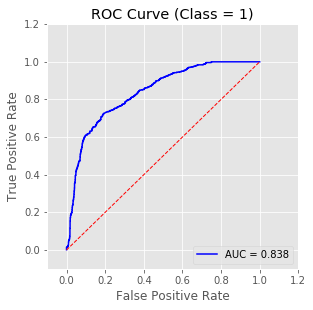

In [28]:
naive_score, fx_features_auc = do_one_model('AUD', best_features, C = au_c, gamma = au_gamma)

### All features

In [29]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('AU_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('AUD', feature_col_names = ['AU_FX'] + cols, do_pca = True)

In [30]:
all_results = accum_results(all_results, 'AUD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Canada

In [31]:
ca_c = 0.03125
ca_gamma = 0.125

### FX rates only

In [32]:
naive_score, fx_auc = do_one_model('CAD', feature_col_names = ['CA_FX'], verbose = 0,
                                  C = ca_c, gamma = ca_gamma)

Time period: 2000-01-03 - 2017-12-12


CA_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.81292


### FX rates and other features

In [33]:
%%capture

best_features, best_score = select_best_features('CAD', 'CA', fx_auc, C = ca_c, gamma = ca_gamma)

In [34]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['CA_FX', 'US_BMP']
Best AUC with test data: 0.89878


Time period: 2000-01-03 - 2017-12-12


CA_FX, US_BMP

Scaled data shape: (6554, 2)
Reframed data shape: (6195, 361)


CA_FX(t-180),US_BMP(t-180),CA_FX(t-179),US_BMP(t-179),CA_FX(t-178),US_BMP(t-178),CA_FX(t-177),US_BMP(t-177),CA_FX(t-176),US_BMP(t-176),CA_FX(t-175),US_BMP(t-175),CA_FX(t-174),US_BMP(t-174),CA_FX(t-173),US_BMP(t-173),CA_FX(t-172),US_BMP(t-172),CA_FX(t-171),US_BMP(t-171),CA_FX(t-170),US_BMP(t-170),CA_FX(t-169),US_BMP(t-169),CA_FX(t-168),US_BMP(t-168),CA_FX(t-167),US_BMP(t-167),CA_FX(t-166),US_BMP(t-166),CA_FX(t-165),US_BMP(t-165),CA_FX(t-164),US_BMP(t-164),CA_FX(t-163),US_BMP(t-163),CA_FX(t-162),US_BMP(t-162),CA_FX(t-161),US_BMP(t-161),CA_FX(t-160),US_BMP(t-160),CA_FX(t-159),US_BMP(t-159),CA_FX(t-158),US_BMP(t-158),CA_FX(t-157),US_BMP(t-157),CA_FX(t-156),US_BMP(t-156),CA_FX(t-155),US_BMP(t-155),CA_FX(t-154),US_BMP(t-154),CA_FX(t-153),US_BMP(t-153),CA_FX(t-152),US_BMP(t-152),CA_FX(t-151),US_BMP(t-151),CA_FX(t-150),US_BMP(t-150),CA_FX(t-149),US_BMP(t-149),CA_FX(t-148),US_BMP(t-148),CA_FX(t-147),US_BMP(t-147),CA_FX(t-146),US_BMP(t-146),CA_FX(t-145),US_BMP(t-145),CA_FX(t-144),US_BMP(t-144),CA_FX(t-143),US_BMP(t-143),CA_FX(t-142),US_BMP(t-142),CA_FX(t-141),US_BMP(t-141),CA_FX(t-140),US_BMP(t-140),CA_FX(t-139),US_BMP(t-139),CA_FX(t-138),US_BMP(t-138),CA_FX(t-137),US_BMP(t-137),CA_FX(t-136),US_BMP(t-136),CA_FX(t-135),US_BMP(t-135),CA_FX(t-134),US_BMP(t-134),CA_FX(t-133),US_BMP(t-133),CA_FX(t-132),US_BMP(t-132),CA_FX(t-131),US_BMP(t-131),CA_FX(t-130),US_BMP(t-130),CA_FX(t-129),US_BMP(t-129),CA_FX(t-128),US_BMP(t-128),CA_FX(t-127),US_BMP(t-127),CA_FX(t-126),US_BMP(t-126),CA_FX(t-125),US_BMP(t-125),CA_FX(t-124),US_BMP(t-124),CA_FX(t-123),US_BMP(t-123),CA_FX(t-122),US_BMP(t-122),CA_FX(t-121),US_BMP(t-121),CA_FX(t-120),US_BMP(t-120),CA_FX(t-119),US_BMP(t-119),CA_FX(t-118),US_BMP(t-118),CA_FX(t-117),US_BMP(t-117),CA_FX(t-116),US_BMP(t-116),CA_FX(t-115),US_BMP(t-115),CA_FX(t-114),US_BMP(t-114),CA_FX(t-113),US_BMP(t-113),CA_FX(t-112),US_BMP(t-112),CA_FX(t-111),US_BMP(t-111),CA_FX(t-110),US_BMP(t-110),CA_FX(t-109),US_BMP(t-109),CA_FX(t-108),US_BMP(t-108),CA_FX(t-107),US_BMP(t-107),CA_FX(t-106),US_BMP(t-106),CA_FX(t-105),US_BMP(t-105),CA_FX(t-104),US_BMP(t-104),CA_FX(t-103),US_BMP(t-103),CA_FX(t-102),US_BMP(t-102),CA_FX(t-101),US_BMP(t-101),CA_FX(t-100),US_BMP(t-100),CA_FX(t-99),US_BMP(t-99),CA_FX(t-98),US_BMP(t-98),CA_FX(t-97),US_BMP(t-97),CA_FX(t-96),US_BMP(t-96),CA_FX(t-95),US_BMP(t-95),CA_FX(t-94),US_BMP(t-94),CA_FX(t-93),US_BMP(t-93),CA_FX(t-92),US_BMP(t-92),CA_FX(t-91),US_BMP(t-91),CA_FX(t-90),US_BMP(t-90),CA_FX(t-89),US_BMP(t-89),CA_FX(t-88),US_BMP(t-88),CA_FX(t-87),US_BMP(t-87),CA_FX(t-86),US_BMP(t-86),CA_FX(t-85),US_BMP(t-85),CA_FX(t-84),US_BMP(t-84),CA_FX(t-83),US_BMP(t-83),CA_FX(t-82),US_BMP(t-82),CA_FX(t-81),US_BMP(t-81),CA_FX(t-80),US_BMP(t-80),CA_FX(t-79),US_BMP(t-79),CA_FX(t-78),US_BMP(t-78),CA_FX(t-77),US_BMP(t-77),CA_FX(t-76),US_BMP(t-76),CA_FX(t-75),US_BMP(t-75),CA_FX(t-74),US_BMP(t-74),CA_FX(t-73),US_BMP(t-73),CA_FX(t-72),US_BMP(t-72),CA_FX(t-71),US_BMP(t-71),CA_FX(t-70),US_BMP(t-70),CA_FX(t-69),US_BMP(t-69),CA_FX(t-68),US_BMP(t-68),CA_FX(t-67),US_BMP(t-67),CA_FX(t-66),US_BMP(t-66),CA_FX(t-65),US_BMP(t-65),CA_FX(t-64),US_BMP(t-64),CA_FX(t-63),US_BMP(t-63),CA_FX(t-62),US_BMP(t-62),CA_FX(t-61),US_BMP(t-61),CA_FX(t-60),US_BMP(t-60),CA_FX(t-59),US_BMP(t-59),CA_FX(t-58),US_BMP(t-58),CA_FX(t-57),US_BMP(t-57),CA_FX(t-56),US_BMP(t-56),CA_FX(t-55),US_BMP(t-55),CA_FX(t-54),US_BMP(t-54),CA_FX(t-53),US_BMP(t-53),CA_FX(t-52),US_BMP(t-52),CA_FX(t-51),US_BMP(t-51),CA_FX(t-50),US_BMP(t-50),CA_FX(t-49),US_BMP(t-49),CA_FX(t-48),US_BMP(t-48),CA_FX(t-47),US_BMP(t-47),CA_FX(t-46),US_BMP(t-46),CA_FX(t-45),US_BMP(t-45),CA_FX(t-44),US_BMP(t-44),CA_FX(t-43),US_BMP(t-43),CA_FX(t-42),US_BMP(t-42),CA_FX(t-41),US_BMP(t-41),CA_FX(t-40),US_BMP(t-40),CA_FX(t-39),US_BMP(t-39),CA_FX(t-38),US_BMP(t-38),CA_FX(t-37),US_BMP(t-37),CA_FX(t-36),US_BMP(t-36),CA_FX(t-35),US_BMP(t-35),CA_FX(t-34),US_BMP(t-34),CA_FX(t-33),US_BMP(t-33),CA_FX(t-32),US_BMP(t-32),CA_FX(t-31),US_BMP(t-31),CA_FX(t-30),US_BMP(t-30),CA_FX(t-29),US_BMP(t-29),CA_FX(t-28),US_BMP(t-28),CA_FX(t-27),U

(4150, 360) (4150,) (2045, 360) (2045,)


AUC: 0.5


AUC: 0.89879



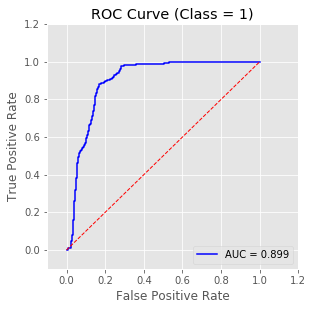

In [35]:
naive_score, fx_features_auc = do_one_model('CAD', feature_col_names = best_features, C = ca_c, gamma = ca_gamma)

### All features

In [36]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CA_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CAD', feature_col_names = ['CA_FX'] + cols, do_pca = True)

In [37]:
all_results = accum_results(all_results, 'CAD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Japan

In [38]:
jp_c = 0.03125
jp_gamma = 0.0078125

### FX rates only

In [39]:
naive_score, fx_auc = do_one_model('JPY', feature_col_names = ['JP_FX'], verbose = 0,
                                  C = jp_c, gamma = jp_gamma)

Time period: 2000-01-03 - 2017-12-12


JP_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.77283


### FX rates and other features

In [40]:
%%capture

best_features, best_score = select_best_features('JPY', 'JP', fx_auc, C = jp_c, gamma = jp_gamma)

In [41]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['JP_FX', 'JP_FX_MA_180', 'US_INT_ON']
Best AUC with test data: 0.94209


Time period: 2000-01-03 - 2017-12-12


JP_FX, JP_FX_MA_180, US_INT_ON

Scaled data shape: (6554, 3)
Reframed data shape: (6195, 541)


JP_FX(t-180),JP_FX_MA_180(t-180),US_INT_ON(t-180),JP_FX(t-179),JP_FX_MA_180(t-179),US_INT_ON(t-179),JP_FX(t-178),JP_FX_MA_180(t-178),US_INT_ON(t-178),JP_FX(t-177),JP_FX_MA_180(t-177),US_INT_ON(t-177),JP_FX(t-176),JP_FX_MA_180(t-176),US_INT_ON(t-176),JP_FX(t-175),JP_FX_MA_180(t-175),US_INT_ON(t-175),JP_FX(t-174),JP_FX_MA_180(t-174),US_INT_ON(t-174),JP_FX(t-173),JP_FX_MA_180(t-173),US_INT_ON(t-173),JP_FX(t-172),JP_FX_MA_180(t-172),US_INT_ON(t-172),JP_FX(t-171),JP_FX_MA_180(t-171),US_INT_ON(t-171),JP_FX(t-170),JP_FX_MA_180(t-170),US_INT_ON(t-170),JP_FX(t-169),JP_FX_MA_180(t-169),US_INT_ON(t-169),JP_FX(t-168),JP_FX_MA_180(t-168),US_INT_ON(t-168),JP_FX(t-167),JP_FX_MA_180(t-167),US_INT_ON(t-167),JP_FX(t-166),JP_FX_MA_180(t-166),US_INT_ON(t-166),JP_FX(t-165),JP_FX_MA_180(t-165),US_INT_ON(t-165),JP_FX(t-164),JP_FX_MA_180(t-164),US_INT_ON(t-164),JP_FX(t-163),JP_FX_MA_180(t-163),US_INT_ON(t-163),JP_FX(t-162),JP_FX_MA_180(t-162),US_INT_ON(t-162),JP_FX(t-161),JP_FX_MA_180(t-161),US_INT_ON(t-161),JP_FX(t-160),JP_FX_MA_180(t-160),US_INT_ON(t-160),JP_FX(t-159),JP_FX_MA_180(t-159),US_INT_ON(t-159),JP_FX(t-158),JP_FX_MA_180(t-158),US_INT_ON(t-158),JP_FX(t-157),JP_FX_MA_180(t-157),US_INT_ON(t-157),JP_FX(t-156),JP_FX_MA_180(t-156),US_INT_ON(t-156),JP_FX(t-155),JP_FX_MA_180(t-155),US_INT_ON(t-155),JP_FX(t-154),JP_FX_MA_180(t-154),US_INT_ON(t-154),JP_FX(t-153),JP_FX_MA_180(t-153),US_INT_ON(t-153),JP_FX(t-152),JP_FX_MA_180(t-152),US_INT_ON(t-152),JP_FX(t-151),JP_FX_MA_180(t-151),US_INT_ON(t-151),JP_FX(t-150),JP_FX_MA_180(t-150),US_INT_ON(t-150),JP_FX(t-149),JP_FX_MA_180(t-149),US_INT_ON(t-149),JP_FX(t-148),JP_FX_MA_180(t-148),US_INT_ON(t-148),JP_FX(t-147),JP_FX_MA_180(t-147),US_INT_ON(t-147),JP_FX(t-146),JP_FX_MA_180(t-146),US_INT_ON(t-146),JP_FX(t-145),JP_FX_MA_180(t-145),US_INT_ON(t-145),JP_FX(t-144),JP_FX_MA_180(t-144),US_INT_ON(t-144),JP_FX(t-143),JP_FX_MA_180(t-143),US_INT_ON(t-143),JP_FX(t-142),JP_FX_MA_180(t-142),US_INT_ON(t-142),JP_FX(t-141),JP_FX_MA_180(t-141),US_INT_ON(t-141),JP_FX(t-140),JP_FX_MA_180(t-140),US_INT_ON(t-140),JP_FX(t-139),JP_FX_MA_180(t-139),US_INT_ON(t-139),JP_FX(t-138),JP_FX_MA_180(t-138),US_INT_ON(t-138),JP_FX(t-137),JP_FX_MA_180(t-137),US_INT_ON(t-137),JP_FX(t-136),JP_FX_MA_180(t-136),US_INT_ON(t-136),JP_FX(t-135),JP_FX_MA_180(t-135),US_INT_ON(t-135),JP_FX(t-134),JP_FX_MA_180(t-134),US_INT_ON(t-134),JP_FX(t-133),JP_FX_MA_180(t-133),US_INT_ON(t-133),JP_FX(t-132),JP_FX_MA_180(t-132),US_INT_ON(t-132),JP_FX(t-131),JP_FX_MA_180(t-131),US_INT_ON(t-131),JP_FX(t-130),JP_FX_MA_180(t-130),US_INT_ON(t-130),JP_FX(t-129),JP_FX_MA_180(t-129),US_INT_ON(t-129),JP_FX(t-128),JP_FX_MA_180(t-128),US_INT_ON(t-128),JP_FX(t-127),JP_FX_MA_180(t-127),US_INT_ON(t-127),JP_FX(t-126),JP_FX_MA_180(t-126),US_INT_ON(t-126),JP_FX(t-125),JP_FX_MA_180(t-125),US_INT_ON(t-125),JP_FX(t-124),JP_FX_MA_180(t-124),US_INT_ON(t-124),JP_FX(t-123),JP_FX_MA_180(t-123),US_INT_ON(t-123),JP_FX(t-122),JP_FX_MA_180(t-122),US_INT_ON(t-122),JP_FX(t-121),JP_FX_MA_180(t-121),US_INT_ON(t-121),JP_FX(t-120),JP_FX_MA_180(t-120),US_INT_ON(t-120),JP_FX(t-119),JP_FX_MA_180(t-119),US_INT_ON(t-119),JP_FX(t-118),JP_FX_MA_180(t-118),US_INT_ON(t-118),JP_FX(t-117),JP_FX_MA_180(t-117),US_INT_ON(t-117),JP_FX(t-116),JP_FX_MA_180(t-116),US_INT_ON(t-116),JP_FX(t-115),JP_FX_MA_180(t-115),US_INT_ON(t-115),JP_FX(t-114),JP_FX_MA_180(t-114),US_INT_ON(t-114),JP_FX(t-113),JP_FX_MA_180(t-113),US_INT_ON(t-113),JP_FX(t-112),JP_FX_MA_180(t-112),US_INT_ON(t-112),JP_FX(t-111),JP_FX_MA_180(t-111),US_INT_ON(t-111),JP_FX(t-110),JP_FX_MA_180(t-110),US_INT_ON(t-110),JP_FX(t-109),JP_FX_MA_180(t-109),US_INT_ON(t-109),JP_FX(t-108),JP_FX_MA_180(t-108),US_INT_ON(t-108),JP_FX(t-107),JP_FX_MA_180(t-107),US_INT_ON(t-107),JP_FX(t-106),JP_FX_MA_180(t-106),US_INT_ON(t-106),JP_FX(t-105),JP_FX_MA_180(t-105),US_INT_ON(t-105),JP_FX(t-104),JP_FX_MA_180(t-104),US_INT_ON(t-104),JP_FX(t-103),JP_FX_MA_180(t-103),US_INT_ON(t-103),JP_FX(t-102),JP_FX_MA_180(t-102),US_INT_ON(t-102),JP_FX(t-101),JP_FX_MA_180(t-101),US_INT_ON(t-101),

(4150, 540) (4150,) (2045, 540) (2045,)


AUC: 0.5


AUC: 0.94209



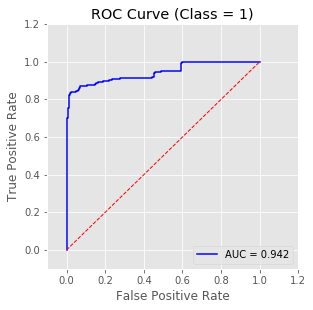

In [42]:
naive_score, fx_features_auc = do_one_model('JPY', feature_col_names = best_features, C = jp_c, gamma = jp_gamma)

### All features

In [43]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('JP_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('JPY', feature_col_names = ['JP_FX'] + cols, do_pca = True)

In [44]:
all_results = accum_results(all_results, 'JPY', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Switzerland

In [45]:
ch_c = 0.125
ch_gamma = 0.5

### FX rates only

In [46]:
naive_score, fx_auc = do_one_model('CHF', feature_col_names = ['CH_FX'], verbose = 0,
                                  C = ch_c, gamma = ch_gamma)

Time period: 2000-01-03 - 2017-12-12


CH_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.74065


### FX rates and other features

In [47]:
%%capture

best_features, best_score = select_best_features('CHF', 'CH', fx_auc, C = ch_c, gamma = ch_gamma)

In [48]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['CH_FX', 'CH_POP', 'CH_FX_MA_180', 'CH_DEBT', 'US_INT_MORTGAGE']
Best AUC with test data: 0.88867


Time period: 2000-01-03 - 2012-12-08


CH_FX, CH_POP, CH_FX_MA_180, CH_DEBT, US_INT_MORTGAGE

Scaled data shape: (4724, 5)
Reframed data shape: (4365, 901)


CH_FX(t-180),CH_POP(t-180),CH_FX_MA_180(t-180),CH_DEBT(t-180),US_INT_MORTGAGE(t-180),CH_FX(t-179),CH_POP(t-179),CH_FX_MA_180(t-179),CH_DEBT(t-179),US_INT_MORTGAGE(t-179),CH_FX(t-178),CH_POP(t-178),CH_FX_MA_180(t-178),CH_DEBT(t-178),US_INT_MORTGAGE(t-178),CH_FX(t-177),CH_POP(t-177),CH_FX_MA_180(t-177),CH_DEBT(t-177),US_INT_MORTGAGE(t-177),CH_FX(t-176),CH_POP(t-176),CH_FX_MA_180(t-176),CH_DEBT(t-176),US_INT_MORTGAGE(t-176),CH_FX(t-175),CH_POP(t-175),CH_FX_MA_180(t-175),CH_DEBT(t-175),US_INT_MORTGAGE(t-175),CH_FX(t-174),CH_POP(t-174),CH_FX_MA_180(t-174),CH_DEBT(t-174),US_INT_MORTGAGE(t-174),CH_FX(t-173),CH_POP(t-173),CH_FX_MA_180(t-173),CH_DEBT(t-173),US_INT_MORTGAGE(t-173),CH_FX(t-172),CH_POP(t-172),CH_FX_MA_180(t-172),CH_DEBT(t-172),US_INT_MORTGAGE(t-172),CH_FX(t-171),CH_POP(t-171),CH_FX_MA_180(t-171),CH_DEBT(t-171),US_INT_MORTGAGE(t-171),CH_FX(t-170),CH_POP(t-170),CH_FX_MA_180(t-170),CH_DEBT(t-170),US_INT_MORTGAGE(t-170),CH_FX(t-169),CH_POP(t-169),CH_FX_MA_180(t-169),CH_DEBT(t-169),US_INT_MORTGAGE(t-169),CH_FX(t-168),CH_POP(t-168),CH_FX_MA_180(t-168),CH_DEBT(t-168),US_INT_MORTGAGE(t-168),CH_FX(t-167),CH_POP(t-167),CH_FX_MA_180(t-167),CH_DEBT(t-167),US_INT_MORTGAGE(t-167),CH_FX(t-166),CH_POP(t-166),CH_FX_MA_180(t-166),CH_DEBT(t-166),US_INT_MORTGAGE(t-166),CH_FX(t-165),CH_POP(t-165),CH_FX_MA_180(t-165),CH_DEBT(t-165),US_INT_MORTGAGE(t-165),CH_FX(t-164),CH_POP(t-164),CH_FX_MA_180(t-164),CH_DEBT(t-164),US_INT_MORTGAGE(t-164),CH_FX(t-163),CH_POP(t-163),CH_FX_MA_180(t-163),CH_DEBT(t-163),US_INT_MORTGAGE(t-163),CH_FX(t-162),CH_POP(t-162),CH_FX_MA_180(t-162),CH_DEBT(t-162),US_INT_MORTGAGE(t-162),CH_FX(t-161),CH_POP(t-161),CH_FX_MA_180(t-161),CH_DEBT(t-161),US_INT_MORTGAGE(t-161),CH_FX(t-160),CH_POP(t-160),CH_FX_MA_180(t-160),CH_DEBT(t-160),US_INT_MORTGAGE(t-160),CH_FX(t-159),CH_POP(t-159),CH_FX_MA_180(t-159),CH_DEBT(t-159),US_INT_MORTGAGE(t-159),CH_FX(t-158),CH_POP(t-158),CH_FX_MA_180(t-158),CH_DEBT(t-158),US_INT_MORTGAGE(t-158),CH_FX(t-157),CH_POP(t-157),CH_FX_MA_180(t-157),CH_DEBT(t-157),US_INT_MORTGAGE(t-157),CH_FX(t-156),CH_POP(t-156),CH_FX_MA_180(t-156),CH_DEBT(t-156),US_INT_MORTGAGE(t-156),CH_FX(t-155),CH_POP(t-155),CH_FX_MA_180(t-155),CH_DEBT(t-155),US_INT_MORTGAGE(t-155),CH_FX(t-154),CH_POP(t-154),CH_FX_MA_180(t-154),CH_DEBT(t-154),US_INT_MORTGAGE(t-154),CH_FX(t-153),CH_POP(t-153),CH_FX_MA_180(t-153),CH_DEBT(t-153),US_INT_MORTGAGE(t-153),CH_FX(t-152),CH_POP(t-152),CH_FX_MA_180(t-152),CH_DEBT(t-152),US_INT_MORTGAGE(t-152),CH_FX(t-151),CH_POP(t-151),CH_FX_MA_180(t-151),CH_DEBT(t-151),US_INT_MORTGAGE(t-151),CH_FX(t-150),CH_POP(t-150),CH_FX_MA_180(t-150),CH_DEBT(t-150),US_INT_MORTGAGE(t-150),CH_FX(t-149),CH_POP(t-149),CH_FX_MA_180(t-149),CH_DEBT(t-149),US_INT_MORTGAGE(t-149),CH_FX(t-148),CH_POP(t-148),CH_FX_MA_180(t-148),CH_DEBT(t-148),US_INT_MORTGAGE(t-148),CH_FX(t-147),CH_POP(t-147),CH_FX_MA_180(t-147),CH_DEBT(t-147),US_INT_MORTGAGE(t-147),CH_FX(t-146),CH_POP(t-146),CH_FX_MA_180(t-146),CH_DEBT(t-146),US_INT_MORTGAGE(t-146),CH_FX(t-145),CH_POP(t-145),CH_FX_MA_180(t-145),CH_DEBT(t-145),US_INT_MORTGAGE(t-145),CH_FX(t-144),CH_POP(t-144),CH_FX_MA_180(t-144),CH_DEBT(t-144),US_INT_MORTGAGE(t-144),CH_FX(t-143),CH_POP(t-143),CH_FX_MA_180(t-143),CH_DEBT(t-143),US_INT_MORTGAGE(t-143),CH_FX(t-142),CH_POP(t-142),CH_FX_MA_180(t-142),CH_DEBT(t-142),US_INT_MORTGAGE(t-142),CH_FX(t-141),CH_POP(t-141),CH_FX_MA_180(t-141),CH_DEBT(t-141),US_INT_MORTGAGE(t-141),CH_FX(t-140),CH_POP(t-140),CH_FX_MA_180(t-140),CH_DEBT(t-140),US_INT_MORTGAGE(t-140),CH_FX(t-139),CH_POP(t-139),CH_FX_MA_180(t-139),CH_DEBT(t-139),US_INT_MORTGAGE(t-139),CH_FX(t-138),CH_POP(t-138),CH_FX_MA_180(t-138),CH_DEBT(t-138),US_INT_MORTGAGE(t-138),CH_FX(t-137),CH_POP(t-137),CH_FX_MA_180(t-137),CH_DEBT(t-137),US_INT_MORTGAGE(t-137),CH_FX(t-136),CH_POP(t-136),CH_FX_MA_180(t-136),CH_DEBT(t-136),US_INT_MORTGAGE(t-136),CH_FX(t-135),CH_POP(t-135),CH_FX_MA_180(t-135),CH_DEBT(t-135),US_INT_MORTGAGE(t-135),CH_FX(t-134),CH_POP(t-134),CH_FX_MA_180(t-134),CH_DEBT(t-134),US_INT_MORTGAGE(t-134),CH_FX

(2924, 900) (2924,) (1441, 900) (1441,)


AUC: 0.5


AUC: 0.88864



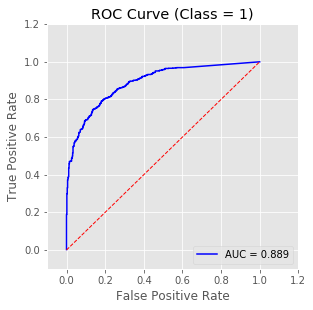

In [49]:
naive_score, fx_features_auc = do_one_model('CHF', feature_col_names = best_features, C = ch_c, gamma = ch_gamma)

### All features

In [50]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CH_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CHF', feature_col_names = ['CH_FX'] + cols, do_pca = True)

In [51]:
all_results = accum_results(all_results, 'CHF', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## UK

In [52]:
uk_c = 1
uk_gamma = 0.5

### FX rates only

In [53]:
naive_score, fx_auc = do_one_model('GBP', feature_col_names = ['UK_FX'], verbose = 0,
                                  C = uk_c, gamma = uk_gamma)

Time period: 2000-01-03 - 2017-12-12


UK_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.7906


### FX rates and other features

In [54]:
%%capture

best_features, best_score = select_best_features('GBP', 'UK', fx_auc, C = uk_c, gamma = uk_gamma)

In [55]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['UK_FX']
Best AUC with test data: 0.7906


Time period: 2000-01-03 - 2017-12-12


UK_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


UK_FX(t-180),UK_FX(t-179),UK_FX(t-178),UK_FX(t-177),UK_FX(t-176),UK_FX(t-175),UK_FX(t-174),UK_FX(t-173),UK_FX(t-172),UK_FX(t-171),UK_FX(t-170),UK_FX(t-169),UK_FX(t-168),UK_FX(t-167),UK_FX(t-166),UK_FX(t-165),UK_FX(t-164),UK_FX(t-163),UK_FX(t-162),UK_FX(t-161),UK_FX(t-160),UK_FX(t-159),UK_FX(t-158),UK_FX(t-157),UK_FX(t-156),UK_FX(t-155),UK_FX(t-154),UK_FX(t-153),UK_FX(t-152),UK_FX(t-151),UK_FX(t-150),UK_FX(t-149),UK_FX(t-148),UK_FX(t-147),UK_FX(t-146),UK_FX(t-145),UK_FX(t-144),UK_FX(t-143),UK_FX(t-142),UK_FX(t-141),UK_FX(t-140),UK_FX(t-139),UK_FX(t-138),UK_FX(t-137),UK_FX(t-136),UK_FX(t-135),UK_FX(t-134),UK_FX(t-133),UK_FX(t-132),UK_FX(t-131),UK_FX(t-130),UK_FX(t-129),UK_FX(t-128),UK_FX(t-127),UK_FX(t-126),UK_FX(t-125),UK_FX(t-124),UK_FX(t-123),UK_FX(t-122),UK_FX(t-121),UK_FX(t-120),UK_FX(t-119),UK_FX(t-118),UK_FX(t-117),UK_FX(t-116),UK_FX(t-115),UK_FX(t-114),UK_FX(t-113),UK_FX(t-112),UK_FX(t-111),UK_FX(t-110),UK_FX(t-109),UK_FX(t-108),UK_FX(t-107),UK_FX(t-106),UK_FX(t-105),UK_FX(t-104),UK_FX(t-103),UK_FX(t-102),UK_FX(t-101),UK_FX(t-100),UK_FX(t-99),UK_FX(t-98),UK_FX(t-97),UK_FX(t-96),UK_FX(t-95),UK_FX(t-94),UK_FX(t-93),UK_FX(t-92),UK_FX(t-91),UK_FX(t-90),UK_FX(t-89),UK_FX(t-88),UK_FX(t-87),UK_FX(t-86),UK_FX(t-85),UK_FX(t-84),UK_FX(t-83),UK_FX(t-82),UK_FX(t-81),UK_FX(t-80),UK_FX(t-79),UK_FX(t-78),UK_FX(t-77),UK_FX(t-76),UK_FX(t-75),UK_FX(t-74),UK_FX(t-73),UK_FX(t-72),UK_FX(t-71),UK_FX(t-70),UK_FX(t-69),UK_FX(t-68),UK_FX(t-67),UK_FX(t-66),UK_FX(t-65),UK_FX(t-64),UK_FX(t-63),UK_FX(t-62),UK_FX(t-61),UK_FX(t-60),UK_FX(t-59),UK_FX(t-58),UK_FX(t-57),UK_FX(t-56),UK_FX(t-55),UK_FX(t-54),UK_FX(t-53),UK_FX(t-52),UK_FX(t-51),UK_FX(t-50),UK_FX(t-49),UK_FX(t-48),UK_FX(t-47),UK_FX(t-46),UK_FX(t-45),UK_FX(t-44),UK_FX(t-43),UK_FX(t-42),UK_FX(t-41),UK_FX(t-40),UK_FX(t-39),UK_FX(t-38),UK_FX(t-37),UK_FX(t-36),UK_FX(t-35),UK_FX(t-34),UK_FX(t-33),UK_FX(t-32),UK_FX(t-31),UK_FX(t-30),UK_FX(t-29),UK_FX(t-28),UK_FX(t-27),UK_FX(t-26),UK_FX(t-25),UK_FX(t-24),UK_FX(t-23),UK_FX(t-22),UK_FX(t-21),UK_FX(t-20),UK_FX(t-19),UK_FX(t-18),UK_FX(t-17),UK_FX(t-16),UK_FX(t-15),UK_FX(t-14),UK_FX(t-13),UK_FX(t-12),UK_FX(t-11),UK_FX(t-10),UK_FX(t-9),UK_FX(t-8),UK_FX(t-7),UK_FX(t-6),UK_FX(t-5),UK_FX(t-4),UK_FX(t-3),UK_FX(t-2),UK_FX(t-1),Is_Up
0.462052,0.473181,0.478188,0.484865,0.474738,0.474368,0.473997,0.473626,0.485422,0.483753,0.485644,0.471289,0.471789,0.472290,0.472791,0.474293,0.480748,0.491876,0.488093,0.488686,0.489280,0.489873,0.485644,0.475963,0.472402,0.455375,0.454336,0.453298,0.452259,0.448698,0.438682,0.434787,0.422546,0.422620,0.422695,0.422769,0.443690,0.444803,0.438349,0.423436,0.422212,0.420988,0.419764,0.426441,0.436457,0.437570,0.430225,0.433582,0.436939,0.440296,0.450367,0.437236,0.429891,0.421767,0.422769,0.423770,0.424772,0.407523,0.415201,0.405854,0.410861,0.407968,0.405075,0.402181,0.406633,0.415869,0.411418,0.408970,0.408561,0.408153,0.407745,0.401402,0.401959,0.403850,0.399176,0.398472,0.397767,0.397062,0.401402,0.399176,0.413087,0.421990,0.419950,0.417909,0.415869,0.417761,0.417538,0.423325,0.423325,0.425477,0.427628,0.429780,0.428110,0.420877,0.409748,0.413087,0.413013,0.412939,0.412864,0.417872,0.418874,0.418763,0.416426,0.416166,0.415906,0.415647,0.405742,0.407189,0.409860,0.408079,0.408636,0.409192,0.409748,0.408302,0.409192,0.403962,0.383040,0.382966,0.382892,0.382818,0.386379,0.388048,0.369130,0.352771,0.353587,0.354403,0.355219,0.355776,0.337748,0.320387,0.339862,0.336264,0.332666,0.329067,0.321611,0.310149,0.300467,0.304585,0.306514,0.308443,0.310372,0.290452,0.293456,0.287892,0.306811,0.308202,0.309593,0.310984,0.315157,0.317160,0.311262,0.329513,0.331590,0.333667,0.335744,0.346873,0.345760,0.327398,0.329513,0.331033,0.332554,0.334075,0.335188,0.323281,0.332183,0.339083,0.338675,0.338267,0.337859,0.331850,0.317383,0.332962,0.321834,0.321092,0.320350,0.319608,0.320721,0.332629,0.342310,0.335188,0
0.473181,0.478188,0.484865,0.474738,0.474368,0.473997,0.473626,0.485422,0.483753,0.485644,0.471289,0.471789,0.472290,0.472791,0.474293,0.480

(4150, 180) (4150,) (2045, 180) (2045,)


AUC: 0.5


AUC: 0.79064



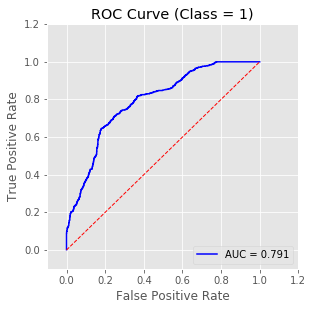

In [56]:
naive_score, fx_features_auc = do_one_model('GBP', feature_col_names = best_features, C = uk_c, gamma = uk_gamma)

### All features

In [57]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('UK_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('GBP', feature_col_names = ['UK_FX'] + cols, do_pca = True)

In [58]:
all_results = accum_results(all_results, 'GBP', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Europe

In [59]:
eu_c = 0.5
eu_gamma = 0.5

In [60]:
naive_score, fx_auc = do_one_model('EUR', feature_col_names = ['EU_FX'], verbose = 0,
                                  C = eu_c, gamma = eu_gamma)

Time period: 2000-01-03 - 2017-12-12


EU_FX

Scaled data shape: (6554, 1)
Reframed data shape: (6195, 181)


AUC: 0.5


AUC: 0.7051


### FX rates and other features

In [61]:
%%capture

best_features, best_score = select_best_features('EUR', 'EU', fx_auc, C = eu_c, gamma = eu_gamma)

In [62]:
print()
print('Best features: ' + str(best_features))                                                            
print('Best AUC with test data: ' + str(round(best_score, 5)))  


Best features: ['EU_FX', 'US_INT_MORTGAGE']
Best AUC with test data: 0.76531


Time period: 2000-01-03 - 2012-12-08


EU_FX, US_INT_MORTGAGE

Scaled data shape: (4724, 2)
Reframed data shape: (4365, 361)


EU_FX(t-180),US_INT_MORTGAGE(t-180),EU_FX(t-179),US_INT_MORTGAGE(t-179),EU_FX(t-178),US_INT_MORTGAGE(t-178),EU_FX(t-177),US_INT_MORTGAGE(t-177),EU_FX(t-176),US_INT_MORTGAGE(t-176),EU_FX(t-175),US_INT_MORTGAGE(t-175),EU_FX(t-174),US_INT_MORTGAGE(t-174),EU_FX(t-173),US_INT_MORTGAGE(t-173),EU_FX(t-172),US_INT_MORTGAGE(t-172),EU_FX(t-171),US_INT_MORTGAGE(t-171),EU_FX(t-170),US_INT_MORTGAGE(t-170),EU_FX(t-169),US_INT_MORTGAGE(t-169),EU_FX(t-168),US_INT_MORTGAGE(t-168),EU_FX(t-167),US_INT_MORTGAGE(t-167),EU_FX(t-166),US_INT_MORTGAGE(t-166),EU_FX(t-165),US_INT_MORTGAGE(t-165),EU_FX(t-164),US_INT_MORTGAGE(t-164),EU_FX(t-163),US_INT_MORTGAGE(t-163),EU_FX(t-162),US_INT_MORTGAGE(t-162),EU_FX(t-161),US_INT_MORTGAGE(t-161),EU_FX(t-160),US_INT_MORTGAGE(t-160),EU_FX(t-159),US_INT_MORTGAGE(t-159),EU_FX(t-158),US_INT_MORTGAGE(t-158),EU_FX(t-157),US_INT_MORTGAGE(t-157),EU_FX(t-156),US_INT_MORTGAGE(t-156),EU_FX(t-155),US_INT_MORTGAGE(t-155),EU_FX(t-154),US_INT_MORTGAGE(t-154),EU_FX(t-153),US_INT_MORTGAGE(t-153),EU_FX(t-152),US_INT_MORTGAGE(t-152),EU_FX(t-151),US_INT_MORTGAGE(t-151),EU_FX(t-150),US_INT_MORTGAGE(t-150),EU_FX(t-149),US_INT_MORTGAGE(t-149),EU_FX(t-148),US_INT_MORTGAGE(t-148),EU_FX(t-147),US_INT_MORTGAGE(t-147),EU_FX(t-146),US_INT_MORTGAGE(t-146),EU_FX(t-145),US_INT_MORTGAGE(t-145),EU_FX(t-144),US_INT_MORTGAGE(t-144),EU_FX(t-143),US_INT_MORTGAGE(t-143),EU_FX(t-142),US_INT_MORTGAGE(t-142),EU_FX(t-141),US_INT_MORTGAGE(t-141),EU_FX(t-140),US_INT_MORTGAGE(t-140),EU_FX(t-139),US_INT_MORTGAGE(t-139),EU_FX(t-138),US_INT_MORTGAGE(t-138),EU_FX(t-137),US_INT_MORTGAGE(t-137),EU_FX(t-136),US_INT_MORTGAGE(t-136),EU_FX(t-135),US_INT_MORTGAGE(t-135),EU_FX(t-134),US_INT_MORTGAGE(t-134),EU_FX(t-133),US_INT_MORTGAGE(t-133),EU_FX(t-132),US_INT_MORTGAGE(t-132),EU_FX(t-131),US_INT_MORTGAGE(t-131),EU_FX(t-130),US_INT_MORTGAGE(t-130),EU_FX(t-129),US_INT_MORTGAGE(t-129),EU_FX(t-128),US_INT_MORTGAGE(t-128),EU_FX(t-127),US_INT_MORTGAGE(t-127),EU_FX(t-126),US_INT_MORTGAGE(t-126),EU_FX(t-125),US_INT_MORTGAGE(t-125),EU_FX(t-124),US_INT_MORTGAGE(t-124),EU_FX(t-123),US_INT_MORTGAGE(t-123),EU_FX(t-122),US_INT_MORTGAGE(t-122),EU_FX(t-121),US_INT_MORTGAGE(t-121),EU_FX(t-120),US_INT_MORTGAGE(t-120),EU_FX(t-119),US_INT_MORTGAGE(t-119),EU_FX(t-118),US_INT_MORTGAGE(t-118),EU_FX(t-117),US_INT_MORTGAGE(t-117),EU_FX(t-116),US_INT_MORTGAGE(t-116),EU_FX(t-115),US_INT_MORTGAGE(t-115),EU_FX(t-114),US_INT_MORTGAGE(t-114),EU_FX(t-113),US_INT_MORTGAGE(t-113),EU_FX(t-112),US_INT_MORTGAGE(t-112),EU_FX(t-111),US_INT_MORTGAGE(t-111),EU_FX(t-110),US_INT_MORTGAGE(t-110),EU_FX(t-109),US_INT_MORTGAGE(t-109),EU_FX(t-108),US_INT_MORTGAGE(t-108),EU_FX(t-107),US_INT_MORTGAGE(t-107),EU_FX(t-106),US_INT_MORTGAGE(t-106),EU_FX(t-105),US_INT_MORTGAGE(t-105),EU_FX(t-104),US_INT_MORTGAGE(t-104),EU_FX(t-103),US_INT_MORTGAGE(t-103),EU_FX(t-102),US_INT_MORTGAGE(t-102),EU_FX(t-101),US_INT_MORTGAGE(t-101),EU_FX(t-100),US_INT_MORTGAGE(t-100),EU_FX(t-99),US_INT_MORTGAGE(t-99),EU_FX(t-98),US_INT_MORTGAGE(t-98),EU_FX(t-97),US_INT_MORTGAGE(t-97),EU_FX(t-96),US_INT_MORTGAGE(t-96),EU_FX(t-95),US_INT_MORTGAGE(t-95),EU_FX(t-94),US_INT_MORTGAGE(t-94),EU_FX(t-93),US_INT_MORTGAGE(t-93),EU_FX(t-92),US_INT_MORTGAGE(t-92),EU_FX(t-91),US_INT_MORTGAGE(t-91),EU_FX(t-90),US_INT_MORTGAGE(t-90),EU_FX(t-89),US_INT_MORTGAGE(t-89),EU_FX(t-88),US_INT_MORTGAGE(t-88),EU_FX(t-87),US_INT_MORTGAGE(t-87),EU_FX(t-86),US_INT_MORTGAGE(t-86),EU_FX(t-85),US_INT_MORTGAGE(t-85),EU_FX(t-84),US_INT_MORTGAGE(t-84),EU_FX(t-83),US_INT_MORTGAGE(t-83),EU_FX(t-82),US_INT_MORTGAGE(t-82),EU_FX(t-81),US_INT_MORTGAGE(t-81),EU_FX(t-80),US_INT_MORTGAGE(t-80),EU_FX(t-79),US_INT_MORTGAGE(t-79),EU_FX(t-78),US_INT_MORTGAGE(t-78),EU_FX(t-77),US_INT_MORTGAGE(t-77),EU_FX(t-76),US_INT_MORTGAGE(t-76),EU_FX(t-75),US_INT_MORTGAGE(t-75),EU_FX(t-74),US_INT_MORTGAGE(t-74),EU_FX(t-73),US_INT_MORTGAGE(t-73),EU_FX(t-72),US_INT_MORTGAGE(t-72),EU_FX(t-71),US_INT_MORTGAGE(t-71),EU_FX(t-70),US_INT_MORTGAGE(t-70),EU_FX(t-69),US_INT_MORTGAGE(t-69),EU_FX(t-68),US_INT_MORTGAGE(t-

(2924, 360) (2924,) (1441, 360) (1441,)


AUC: 0.5


AUC: 0.76531



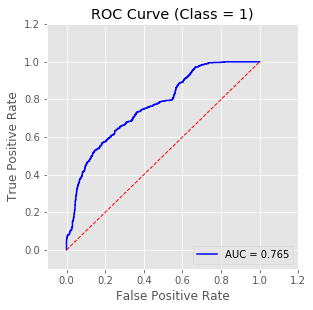

In [63]:
naive_score, fx_features_auc = do_one_model('EUR', feature_col_names = best_features, C = eu_c, gamma = eu_gamma)

# Summary of results

#### Test AUC for all FX rates (relative to USD)

In [64]:
all_results = all_results[['Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]
all_results.to_csv('AUC_SVM_7_Features.csv', index = False)

pd.options.display.float_format = '{:,.5f}'.format
my_linespace()
my_display_df(all_results)

Currency,Naive,FX Only,FX + Features,All Features
AUD,None,0.83778,0.83779,None
CAD,None,0.81292,0.89879,None
JPY,None,0.77283,0.94209,None
CHF,None,0.74065,0.88864,None
GBP,None,0.79060,0.79064,None


#### Visualize test AUC

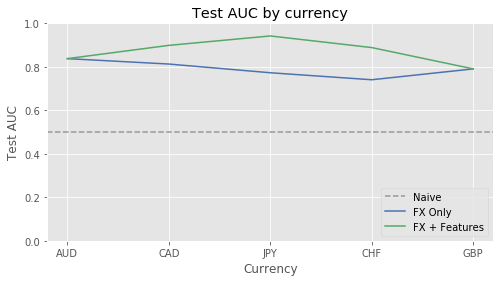

In [65]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 0.5, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results['FX + Features'], label = 'FX + Features')
#ax.plot(range(n_items), all_results['All Features'], label = 'All Features')

ax.set_ylim((0.0, 1.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test AUC')
ax.set_title('Test AUC by currency')

plt.legend(loc = 'lower right')
plt.show()